In [46]:
from pathlib import Path
import pandas as pd
import quantstats as qs

In [42]:
def cache(func):
    def wrapped_func(*args, **kwargs):
        from datetime import date

        table_name = func.__name__.split("_")[-1]
        parquet_path = f"./data/{table_name}.parquet"
        try:
            table = pd.read_parquet(parquet_path)
        except FileNotFoundError:
            table = func(*args, **kwargs)
            table.to_parquet(parquet_path)
        return table

    return wrapped_func

def query(sql_stmt, params, wrds_username):
    import wrds

    with wrds.Connection(wrds_username=wrds_username) as db:
        data = db.raw_sql(sql_stmt, date_cols=["date"], params=params)
    return data

@cache
def get_crsp(permnos, wrds_username):
    sql_crsp = """
    SELECT DISTINCT
      date,
      permno,
      ret,
      prc,
      prc * shrout AS cap
    FROM crsp.dsf
    WHERE permno in %(permnos)s
    AND date >= '1997-01-01'
    AND date <= '2019-12-31';
    """
    params = {"permnos": permnos}
    crsp = query(sql_crsp, params, wrds_username).astype({"permno":"int"})
    return crsp


In [43]:
path = Path("./data")
permno_path = path/"permno_selection.csv"
permnos = pd.read_csv(permno_path, dtype={"permno":"str"}).squeeze().pipe(tuple)
crsp = get_crsp(permnos, "iewaij")

Loading library list...
Done


In [44]:
crsp = crsp.sort_values(["date", "permno"])
crsp["cap"] = crsp.groupby("permno").cap.shift(1)
crsp["capw"] = crsp.groupby("date").cap.apply(lambda x: x / x.sum())
crsp = crsp.dropna().reset_index(drop=True)

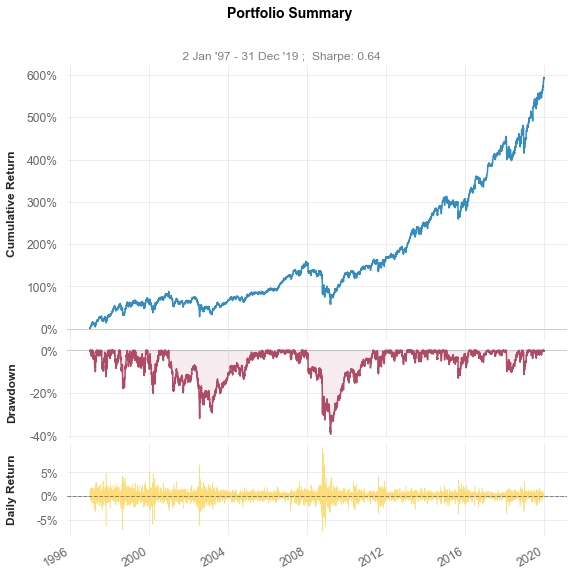

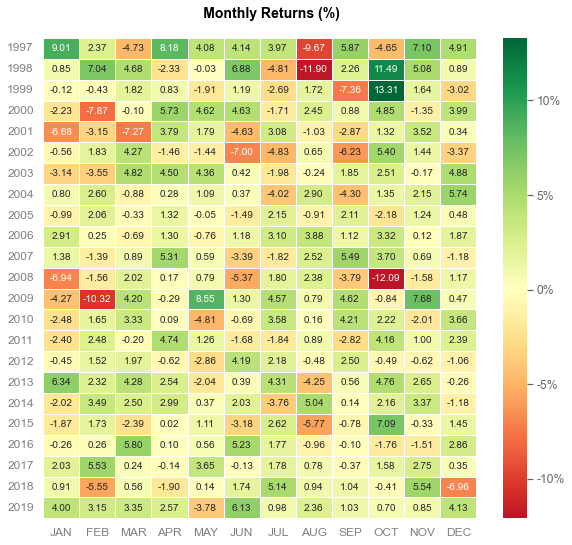

In [49]:
bnch_ret = (crsp.ret * crsp.capw).groupby(crsp.date).sum()
qs.reports.plots(bnch_ret)